# Import image

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import theano
import theano.tensor as T
from PIL import Image
import numpy as np

# theano.config.compute_test_value = 'warn'
theano.config.exception_verbosity= 'high'
theano.config.compute_test_value = 'off'
# theano.config.optimizer = 'None'

batch = ['./datasetFV/000-3-B.jpg']
ImageSize = (256, 256)
NChannelsPerImage = 3
images = [ Image.open(f, 'r') for f in batch ]
for i in images :
    assert i.size == ImageSize
    assert len(i.getbands()) == NChannelsPerImage
 
ImageShape =  (1,) + ImageSize + (NChannelsPerImage,)
allImages = [ np.frombuffer(i.tobytes(), dtype='uint8', count=-1) for i in images ]
allImages = [ np.rollaxis(a.reshape(ImageShape), 3, 1) for a in allImages ]
allImages = np.concatenate(allImages)
print('The allimages shape is: {}'.format(allImages.shape))
print('Operating with the first image')
sample = allImages[0].astype('float32')
print('Sample shape is: {} with dtype={}'.format(sample.shape, sample.dtype))

C:\Users\fabia\AppData\Roaming\Python\Python36\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


The allimages shape is: (1, 3, 256, 256)
Operating with the first image
Sample shape is: (3, 256, 256) with dtype=float32


Using cuDNN version 7402 on context None
Mapped name None to device cuda: GeForce GTX 1060 (0000:01:00.0)


# Map function

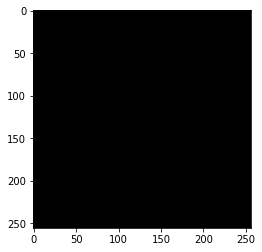

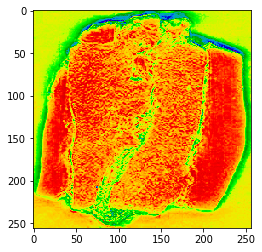

Sumatorio:  13513910.0
[[65536. 65536. 65536. ... 65536. 65536. 65536.]
 [65536. 65536. 65536. ... 65536. 65536. 65536.]
 [65536. 65536. 65536. ... 65536. 65536. 65536.]
 ...
 [65536. 65536. 65536. ... 65536. 65536. 65536.]
 [65536. 65536. 65536. ... 65536. 65536. 65536.]
 [65536. 65536. 65536. ... 65536. 65536. 65536.]]


In [2]:
k = T.iscalar("k")
A = T.matrix("A")
B = T.matrix("B")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda A, B, p: p - p  + B.sum(),
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              sequences=[B],
                              n_steps=k)

final_result = result[-1]

power = theano.function(inputs=[A,k,B], outputs=final_result, updates=updates)
R = sample[0,:,:]
res = power(R, 1, R)

plt.imshow(res, cmap='nipy_spectral')
plt.show()
plt.imshow(R, cmap='nipy_spectral')
plt.show()
print('Sumatorio: ', R.sum())
print(res)

In [8]:
X = T.matrix("X")
W = T.matrix("W")
onepoint = T.vector("onepoint")
sigma_constant = T.scalar("sigma_constant")
n_constant = T.scalar("n_constant")

parzp = (((T.exp(T.sqrt(abs((W-onepoint)**2).sum(1))))/(2*sigma_constant*sigma_constant)).sum())/(2*(sigma_constant**2)*n_constant)
parzen_point = theano.function([onepoint, W, sigma_constant, n_constant], parzp)

def parzen_loop(V, Q, n):
    pmask = np.zeros((n, 1))
    for i in range(n):
        pmask[i] = parzen_point(V[i], Q, 0.5, n)
    return pmask
        

flat = np.rollaxis(sample, 0, 3).reshape((256*256, 3))/255
print('The flat shape is: ', flat.shape)
res = parzen_loop(flat, flat, 256*256)
print('The res shape is :', res.shape)
print(res)



The flat shape is:  (65536, 3)
The res shape is : (65536, 1)
[[5.22845297]
 [5.22845297]
 [5.21111972]
 ...
 [5.2671691 ]
 [5.2471015 ]
 [5.22845297]]


The sample shape is:  (256, 256, 3)
The window shape is:  (4, 4, 3)
The flat shape is:  (16, 3)
4.0358625381111075
The parzen mask shape is: (256, 256)


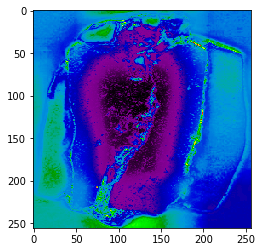

In [48]:
rgbn = np.rollaxis(sample, 0, 3)/255
rgbw = rgbn[:4,:4,:]
rgbwflat = rgbw.reshape((4*4, 3))
print('The sample shape is: ', rgbn.shape)
print('The window shape is: ', rgbw.shape)
print('The flat shape is: ', rgbwflat.shape)
parzsqare = (((T.exp(T.sqrt(abs((W-onepoint)**2).sum(1))))/(2*sigma_constant*sigma_constant)).sum())/(2*(sigma_constant**2)*n_constant)
parzen_point = theano.function([onepoint, W, sigma_constant, n_constant], parzp)
pq = parzen_point(rgbn[0,0], rgbwflat,0.5,16)
print(pq)

def squared_parzen_loop(V, Q):
    pmask = np.zeros((V.shape[0], V.shape[1]))
    ws = 50
    
    for i in range(V.shape[0]):
        i_th = i
        if i <ws:
            i_th = ws
        if i > V.shape[0] - ws:
            i_th = V.shape[0] - ws
        for j in range(V.shape[1]):
            j_th = j
            if j < ws:
                j_th = ws
            if j > V.shape[1] - ws:
                j_th = V.shape[1] - ws
            
            Qflat = Q[i_th-ws:i_th+ws, j_th-ws:j_th+ws, :]
#             print('i: ', i, 'j:', j, 'Params: ', i_th-ws, i_th+ws, ' AND ', j_th-ws, j_th+ws)
#             print('Cropped shape: ', Qflat.shape)
            Qflat = Qflat.reshape((Qflat.shape[0] * Qflat.shape[1], 3))
#             print(Qflat)
#             print('END')
            pmask[i,j] = parzen_point(V[i,j], Qflat, 0.5, Qflat.shape[0] * Qflat.shape[1])
    return pmask

pq = squared_parzen_loop(rgbn, rgbn)
print('The parzen mask shape is:', pq.shape)
plt.imshow(pq, cmap='nipy_spectral')
plt.show()